In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
f_sixb = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel//NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root"
# f_sixb = "/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel//NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root"


In [4]:
sixb = ObjIter([Tree(f_sixb)])

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [5]:
def use_uscms(flist):
    # return flist
    return [ '/eos/uscms'+f for f in flist ]

In [6]:
qcd = ObjIter([Tree( use_uscms(fc.eightb.preselection.t8btag_minmass.Run2_UL18.QCD_B_List) )])

100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


In [7]:
model = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/hx_jet_classifier/20221110_ranger_lr0.0047_batch512/"

In [8]:
t6btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag,axis=1)<6)
sixb = sixb.apply(t6btag)
qcd = qcd.apply(t6btag)

In [9]:
def load_hx_jet_classifier(t, model=model):
    fields = ['top2_score','top2_index'] #+ ['gnn_hx_pt','gnn_hx_m','gnn_hx_eta','gnn_hx_phi','gnn_hx_dr']
    weaver = eightb.load_weaver_output(t, model, fields=fields)
    top2_score, top2_index = [ weaver[field] for field in ('top2_score','top2_index') ]
    top2_index = top2_index.astype(int)

    # w_gnn_hx = { 'w_'+field:weaver[field] for field in ('gnn_hx_pt','gnn_hx_m','gnn_hx_eta','gnn_hx_phi','gnn_hx_dr') }
    # t.extend(**w_gnn_hx)

    top2_index = np.sort(top2_index, axis=-1).reshape(-1,1,2)
    top2_index = ak.from_regular(top2_index, axis=1)

    build_all_dijets(t, pairs=top2_index, name='gnn_hx')
    t.extend(gnn_hx_j1_score=top2_score[:,0], gnn_hx_j2_score=top2_score[:,1])

In [10]:
# (sixb).apply(load_hx_jet_classifier)
(sixb+qcd).apply(load_hx_jet_classifier)


[None, None]

In [11]:
def hx_mask(t):
    sigId = (t.jet_signalId+2)//2
    mask = ak.sum(sigId == 1,axis=-1) == 2
    return mask


In [12]:
varinfo.gnn_hx_m = dict(bins=(0,500,30))

100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


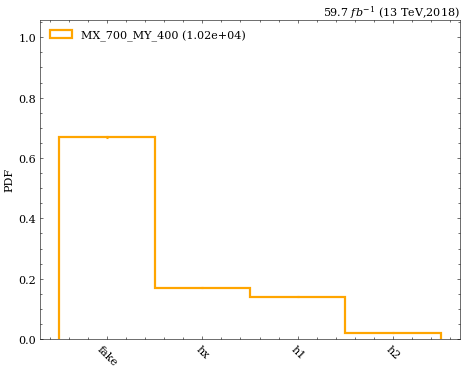

In [13]:
varinfo.gnn_hx_signalId = dict(xlabel=['fake','hx','h1','h2'])

study.quick(
    sixb,
    legend=True,
    # h_label_stat=higgs_comp,
    transforms=lambda v:v+1,
    varlist=['gnn_hx_signalId'],
    efficiency=True,
)

100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


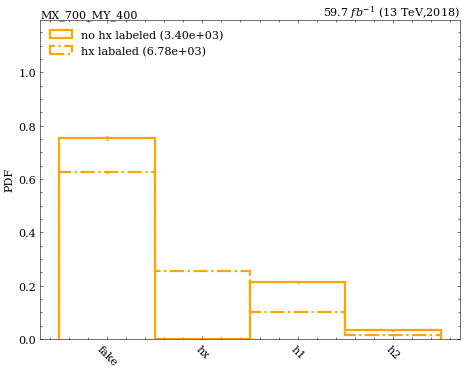

In [25]:
study.compare_masks(
    sixb,
    masks=[lambda t: ~hx_mask(t), lambda t:hx_mask(t)],
    label=['no hx labeled','hx labaled'],
    legend=True,
    # masks=hx_mask,
    transforms=lambda v:v+1,
    varlist=['gnn_hx_signalId'],
    # binlist=[None, (0,500,30)],
    efficiency=True,
)

100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


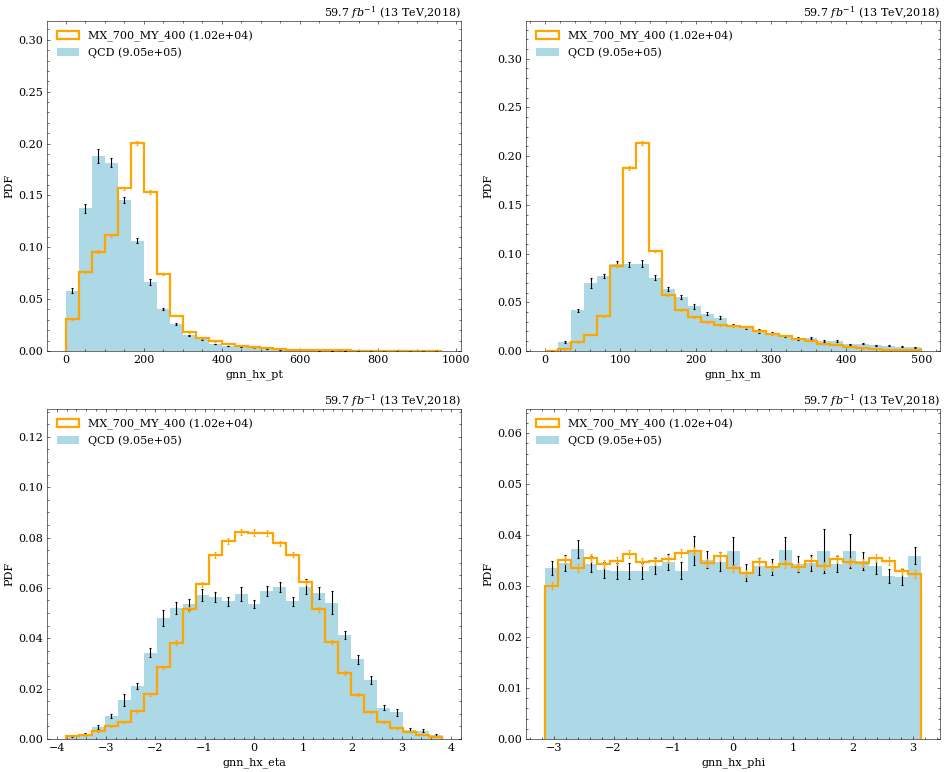

In [14]:
study.quick(
    sixb+qcd,
    legend=True,
    varlist=['gnn_hx_pt','gnn_hx_m','gnn_hx_eta','gnn_hx_phi'],
    efficiency=True,
)

100%|██████████| 3/3 [00:00<00:00,  8.26it/s]


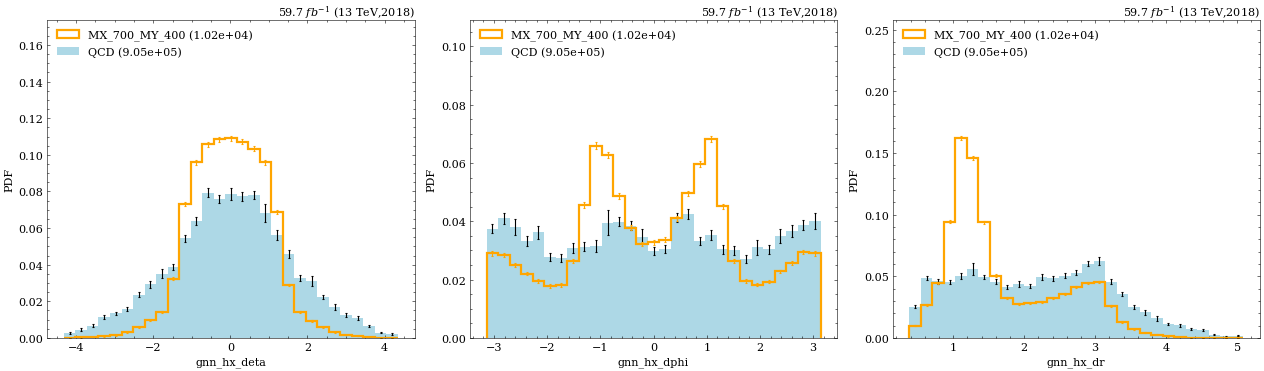

In [15]:
study.quick(
    sixb+qcd,
    legend=True,
    # masks=hx_mask,
    varlist=['gnn_hx_deta','gnn_hx_dphi','gnn_hx_dr'],
    dim=-1,
    efficiency=True,
)

100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


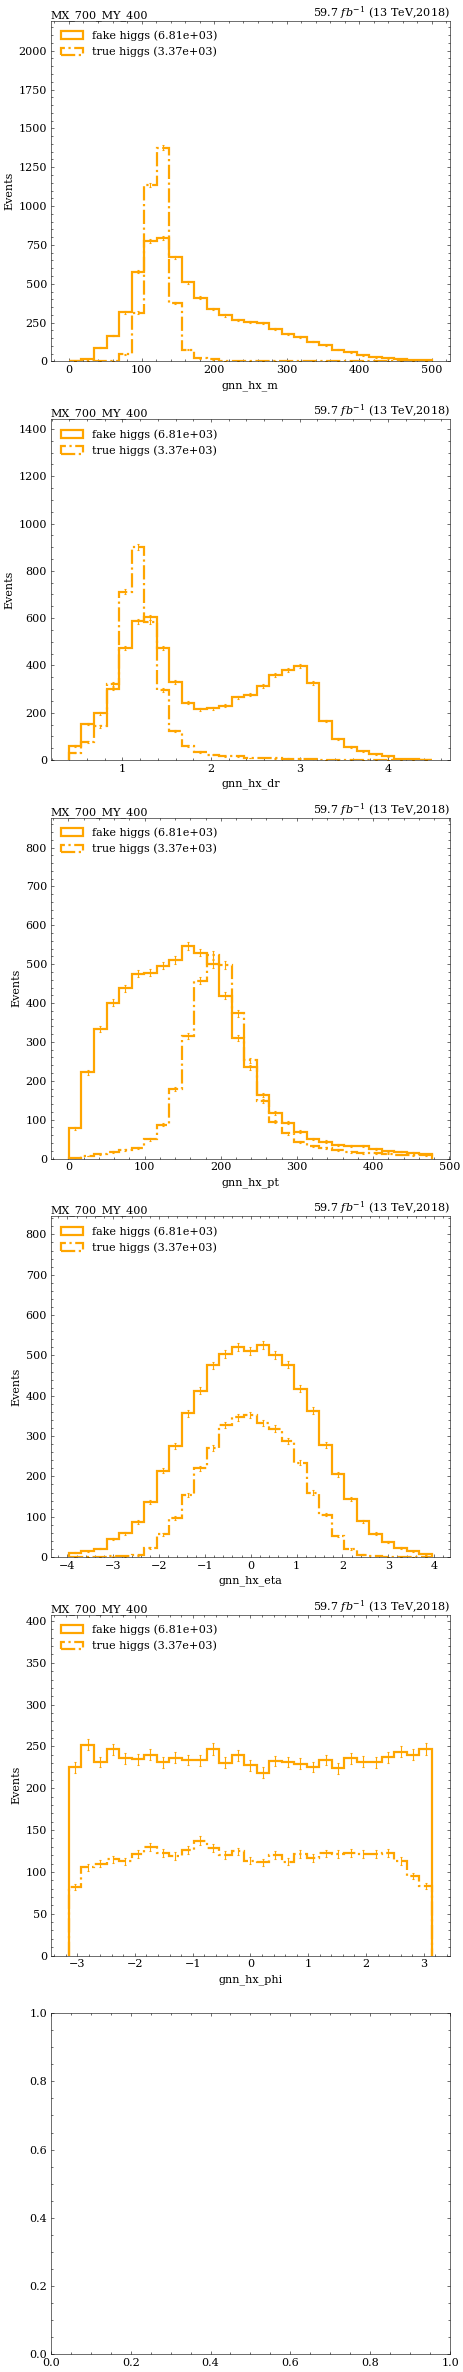

In [16]:
study.compare_masks(
    sixb,
    masks=[lambda t:(t.gnn_hx_signalId[:,0] == -1), lambda t:(t.gnn_hx_signalId[:,0]>=0)],
    label=['fake higgs','true higgs'],
    legend=True,
    # masks=hx_mask,
    varlist=['gnn_hx_m','gnn_hx_dr','gnn_hx_pt','gnn_hx_eta','gnn_hx_phi'],
    # binlist=[None, (0,500,30)],
    # efficiency=True,
    dim=-1,
)

100%|██████████| 1/1 [00:00<00:00, 26.03it/s]


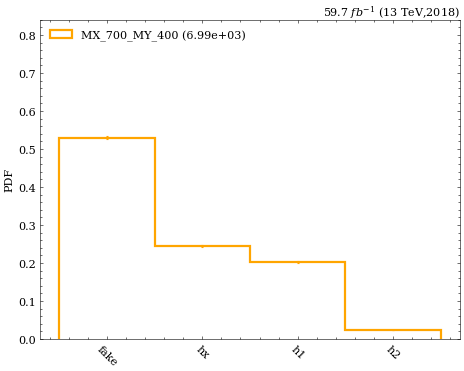

In [17]:

study.quick(
    sixb,
    legend=True,
    masks=lambda t:(t.gnn_hx_dr[:,0]<2),
    # h_label_stat=higgs_comp,
    transforms=lambda v:v+1,
    varlist=['gnn_hx_signalId'],
    efficiency=True,
)

100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


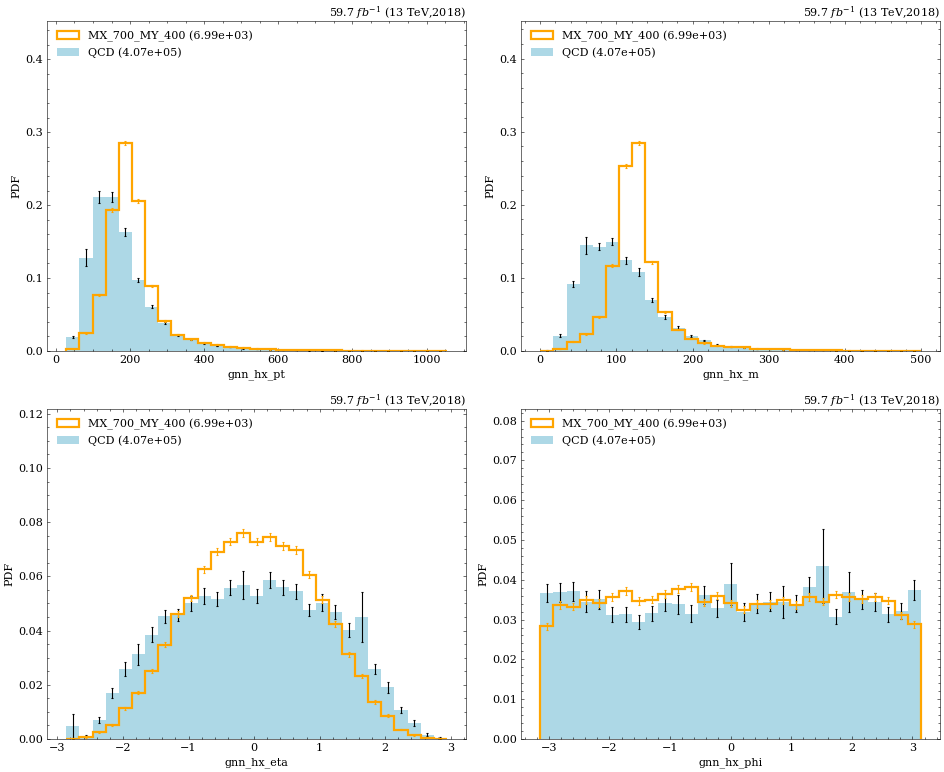

In [18]:
study.quick(
    sixb+qcd,
    legend=True,
    masks=lambda t:(t.gnn_hx_dr[:,0]<2),
    varlist=['gnn_hx_pt','gnn_hx_m','gnn_hx_eta','gnn_hx_phi'],
    efficiency=True,
)

100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


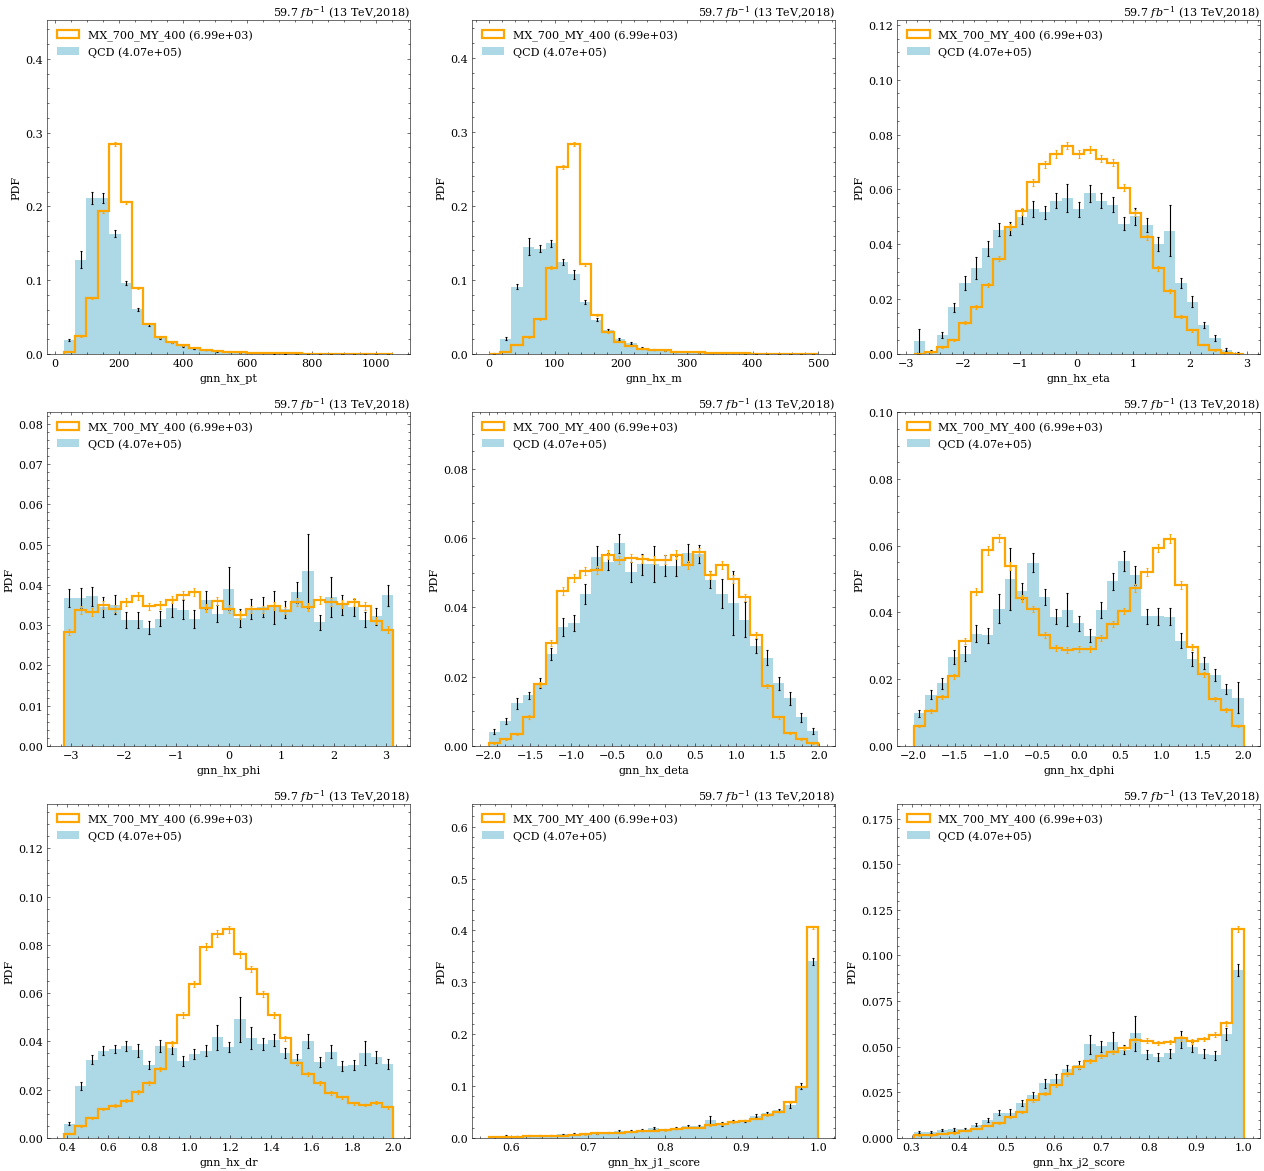

In [19]:
study.quick(
    sixb+qcd,
    legend=True,
    masks=lambda t:t.gnn_hx_dr[:,0]<2,
    varlist=['gnn_hx_pt','gnn_hx_m','gnn_hx_eta','gnn_hx_phi','gnn_hx_deta','gnn_hx_dphi','gnn_hx_dr','gnn_hx_j1_score','gnn_hx_j2_score'],
    binlist=[None, (0,500,30)],
    efficiency=True,
)

100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


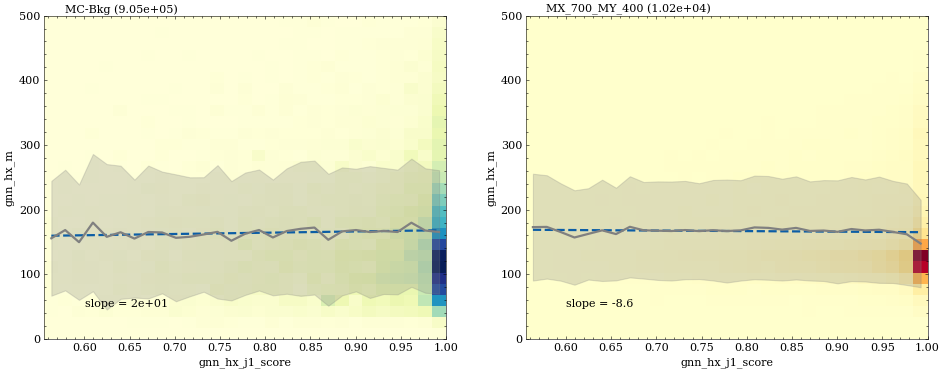

In [20]:
study.quick2d(
    sixb+qcd,
    # log=True,
    varlist=['gnn_hx_j1_score','gnn_hx_m'],
    binlist=[None,(0,500,30)],
    exe=plot_histo2d_x_corr
)

100%|██████████| 5/5 [00:00<00:00, 14.33it/s]


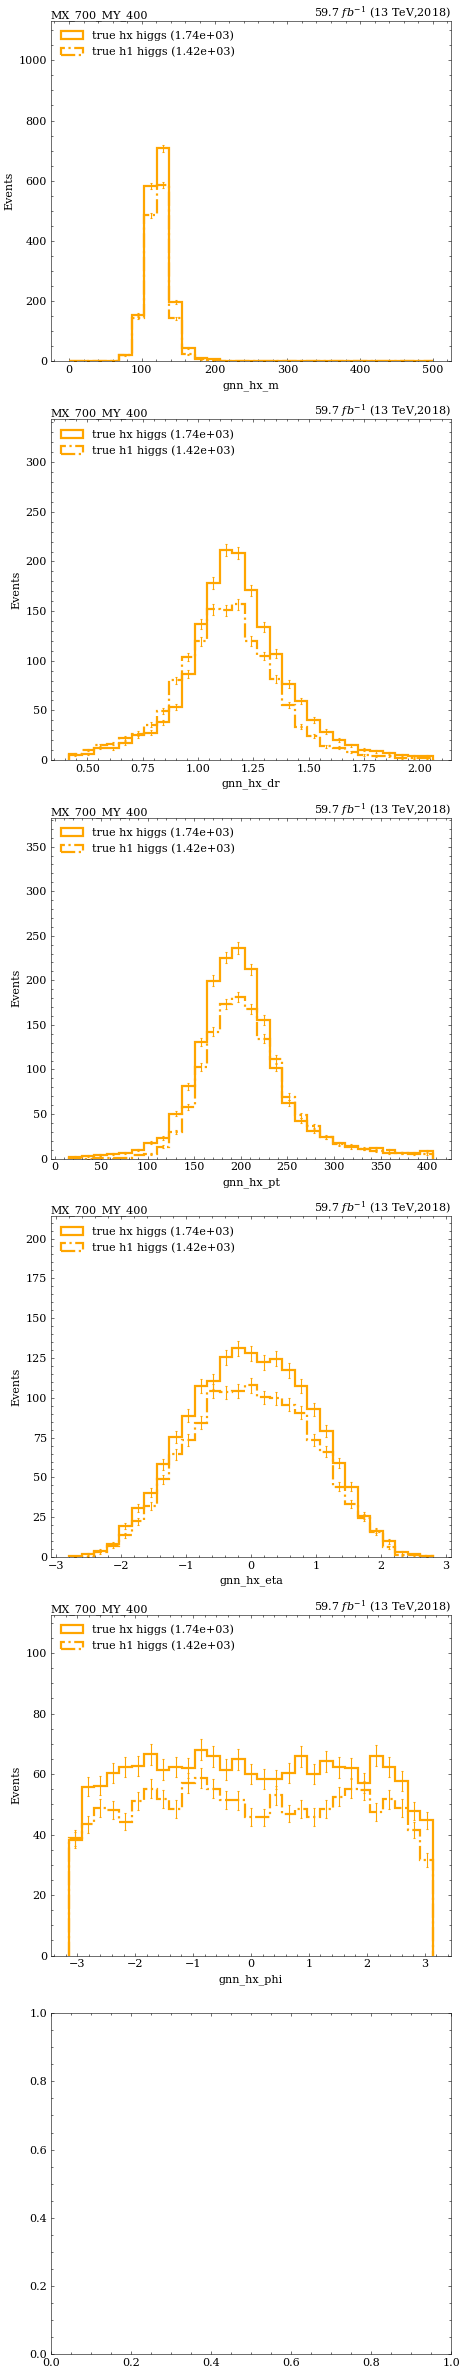

In [21]:
study.compare_masks(
    sixb,
    masks=[lambda t:(t.gnn_hx_signalId[:,0] == 0), lambda t:(t.gnn_hx_signalId[:,0]==1)],
    label=['true hx higgs','true h1 higgs'],
    legend=True,
    # masks=hx_mask,
    varlist=['gnn_hx_m','gnn_hx_dr','gnn_hx_pt','gnn_hx_eta','gnn_hx_phi'],
    # binlist=[None, (0,500,30)],
    # efficiency=True,
    dim=-1,
)